# Testbenches for the DC Analysis

The goal of this notebook is to compare the results from YalRF simulations to what is obtained using Xyce. There are several Xyce netlists in the ./data directory, along with the output data. They were developed with the help of Qucs-S. The netlists are recreated and simulated here using YalRF and the results between the engines are compared.

The testbenches implemented show in a very top-level fashion that the engine works. Nonetheless, a lot of features implemented still must be 'unit-tested'.

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import setup
from Xyce import getXyceData
from yalrf import YalRF

# Circuit 1

![](data/circuit1.png)

In [2]:
y = YalRF("Circuit 1")

y.add_resistor('R1', 'n1', 'n2', 100)
y.add_resistor('R2', 'n2', 'gnd', 25)
y.add_resistor('R3', 'n3', 'n5', 50)
y.add_resistor('R4', 'n7', 'n8', 33)
y.add_resistor('R5', 'n8', 'n5', 66)
y.add_resistor('R6', 'n9', 'gnd', 50)
y.add_capacitor('C1', 'n4', 'n3', 1e-12)
y.add_inductor('L1', 'n4', 'n2', 1e-9)
y.add_inductor('L2', 'n5', 'gnd', 1e-9)

v1 = y.add_vdc('V1', 'n1', 'gnd', 10)
y.add_vdc('V2', 'n3', 'n2', 7)
y.add_idc('I1', 'n4', 'n1', 2)

y.add_vcvs('SRC1', 'n3', 'n7', 'n8', 'n5', 1.7)
y.add_ccvs('SRC2', 'n7', 'n9', 'gnd', 'n5', 12.4)

y.add_dc_analysis('DC1')

# get output from Xyce simulator
xyce = getXyceData('data/circuit1.prn')

# sweep of V1 DC voltage
vsweep = np.arange(1, 11, 1)
i = 0
for v in vsweep:
    # run dc analysis with new dc voltage
    v1.dc = v
    y.run('DC1')

    # get output data
    vn1 = y.get_voltage('DC1', 'n1')
    vn2 = y.get_voltage('DC1', 'n2')
    vn3 = y.get_voltage('DC1', 'n3')
    vn4 = y.get_voltage('DC1', 'n4')
    vn5 = y.get_voltage('DC1', 'n5')
    vn7 = y.get_voltage('DC1', 'n7')
    vn8 = y.get_voltage('DC1', 'n8')
    vn9 = y.get_voltage('DC1', 'n9')

    # compare outputs from Xyce and YalRF
    yalrf_out = [vn1, vn2, vn3, vn4, vn5, vn7, vn8, vn9]
    xyce_out = xyce[1][i][1:]
    print(max(yalrf_out - xyce_out))
    i = i + 1

2.8451578870658523e-08
4.497874783737643e-08
3.970909823181046e-08
4.5337861465100104e-08
1.6438470140656136e-08
2.7296451321490167e-08
3.074495680266409e-08
1.299849827773869e-08
4.505143635924469e-08
2.2046933167985117e-09


# Circuit 2 - Diode IxV characteristic

![](data/circuit2.png)

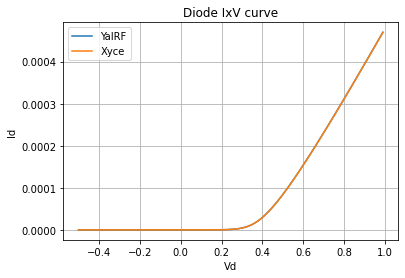

In [3]:
y = YalRF("Circuit 2 - Diode IxV Curve")

y.add_resistor('R1', 'n1', 'n2', 1e3)
vin = y.add_vdc('Vin', 'n1', 'gnd', -10)
d1 = y.add_diode('D1', 'n2', 'gnd')

d1.options['Is'] = 4e-10
d1.options['Rs'] = 500
d1.options['N'] = 1.48
d1.options['Tt'] = 8e-7
d1.options['Cj0'] = 1.95e-11
d1.options['Vj'] = 0.4
d1.options['M'] = 0.38
d1.options['Eg'] = 1.36
d1.options['Xti'] = -8
d1.options['Kf'] = 0
d1.options['Af'] = 1
d1.options['Fc'] = 0.9
d1.options['Bv'] = 600
d1.options['Ibv'] = 1e-4
d1.options['Area'] = 5

y.add_dc_analysis('DC1')

# get output from Xyce simulator
xyce = getXyceData('data/circuit2.prn')

# sweep of Vin DC voltage
vsweep = np.arange(-0.5, 1, 10e-3)
Id = np.empty(len(vsweep))
Id_xyce = np.empty(len(vsweep))
i = 0
for v in vsweep:
    # run dc analysis with new dc voltage
    vin.dc = v
    x = y.run('DC1')

    # get output data
    Id[i] = -x[2,0]
    Id_xyce[i] = xyce[1][i][2]
    i = i + 1

plt.plot(vsweep, Id)
plt.plot(vsweep, Id_xyce)
plt.title('Diode IxV curve')
plt.legend(['YalRF','Xyce'])
plt.xlabel('Vd')
plt.ylabel('Id')
plt.grid()
plt.show()

# Circuit 3 - Diode Clipper

This netlist was taken directly from Xyce's User Guide.

![](data/circuit3.png)

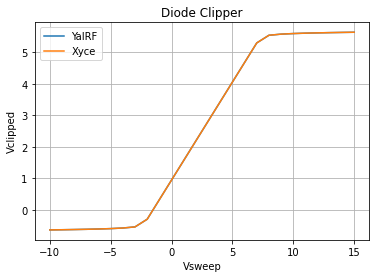

In [4]:
y = YalRF("Circuit 3 - Diode Clipper")

y.add_resistor('R1', 'n2', 'n3', 1e3)
y.add_resistor('R2', 'n1', 'n2', 3.3e3)
y.add_resistor('R3', 'n2', 'gnd', 3.3e3)
y.add_resistor('R4', 'n4', 'gnd', 5.6e3)
y.add_capacitor('C1', 'n2', 'n4', 0.47e-6)

y.add_vdc('Vcc', 'n1', 'gnd', 5)
vin = y.add_vdc('Vin', 'n3', 'gnd', 0)

d1 = y.add_diode('D1', 'n2', 'n1')
d2 = y.add_diode('D2', 'gnd', 'n2')

d1.options['Is'] = 4e-10
d1.options['Rs'] = 0 # not implemented yet
d1.options['N'] = 1.48
d1.options['Tt'] = 8e-7
d1.options['Cj0'] = 1.95e-11
d1.options['Vj'] = 0.4
d1.options['M'] = 0.38
d1.options['Eg'] = 1.36
d1.options['Xti'] = -8
d1.options['Kf'] = 0
d1.options['Af'] = 1
d1.options['Fc'] = 0.9
d1.options['Bv'] = 600
d1.options['Ibv'] = 1e-4
d2.options = d1.options.copy()

dc1 = y.add_dc_analysis('DC1')
#dc1.options['reltol'] = 1e-6

# get output from Xyce
xyce = getXyceData('data/circuit3.prn')

# sweep of Vin DC voltage
vsweep = np.arange(-10, 16, 1)
v2_yalrf = np.empty(len(vsweep))
v2_xyce = np.empty(len(vsweep))
i = 0
for v in vsweep:
    # run dc analysis with new dc voltage
    vin.dc = float(v)
    x = y.run('DC1')

    # get output data
    vn1 = y.get_voltage('DC1', 'n1')
    vn2 = y.get_voltage('DC1', 'n2')
    vn3 = y.get_voltage('DC1', 'n3')
    vn4 = y.get_voltage('DC1', 'n4')

    # compare outputs from Xyce and YalRF
    v2_yalrf[i] = vn2
    v2_xyce[i] = xyce[1][i][2]
    i = i + 1

plt.plot(vsweep, v2_yalrf)
plt.plot(vsweep, v2_xyce)
plt.title('Diode Clipper')
plt.legend(['YalRF','Xyce'])
plt.xlabel('Vsweep')
plt.ylabel('Vclipped')
plt.grid()
plt.show()

# Circuit 4 - BJT Curve Tracer

![](data/circuit4.png)

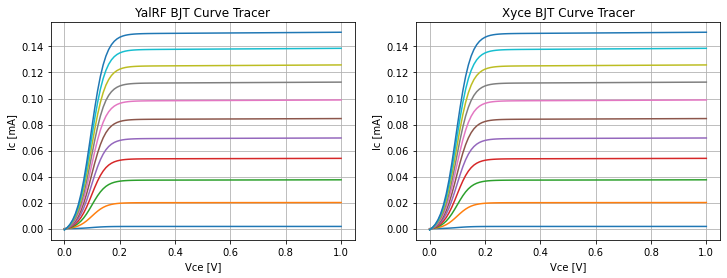

In [5]:
y = YalRF("Circuit 4 - BJT Curve Tracer")

v1 = y.add_vdc('V1', 'nc', 'gnd', 1)
i1 = y.add_idc('I1', 'nb', 'gnd', 1e-6)

q1 = y.add_bjt('Q1', 'nb', 'nc', 'gnd')
q1.options['Is'] = 8.11e-14
q1.options['Nf'] = 1
q1.options['Nr'] = 1
q1.options['Ikf'] = 0.5
q1.options['Ikr'] = 0.225
q1.options['Vaf'] = 113
q1.options['Var'] = 24
q1.options['Ise'] = 1.06e-11
q1.options['Ne'] = 2
q1.options['Isc'] = 0
q1.options['Nc'] = 2
q1.options['Bf'] = 205
q1.options['Br'] = 4

dc1 = y.add_dc_analysis('DC1')

vcesweep = np.linspace(0, 1, 101)
ibsweep = np.linspace(10e-6, 1010e-6, 11)

vbe_yalrf = []
vce_yalrf = []
ib_yalrf = []
ic_yalrf = []
for ib in ibsweep:
    vbe = np.zeros(len(vcesweep))
    ic = np.zeros(len(vcesweep))
    i = 0
    for vce in vcesweep:
        i1.dc = ib
        v1.dc = vce
        x = y.run('DC1')
        vbe[i] = y.get_voltage('DC1', 'nb')
        ic[i] = -x[2,0]
        i = i + 1
    vbe_yalrf.append(vbe)
    vce_yalrf.append(vcesweep)
    ib_yalrf.append(ibsweep)
    ic_yalrf.append(ic)

# get output from Xyce
xyce = np.array(getXyceData('data/circuit4.prn')[1][:])

# number of sweep points in the base current
sweeplength = 11

# split the solution into arrays for each base current
vbe_xyce = np.split(xyce[:,1], sweeplength)
vce_xyce = np.split(xyce[:,2], sweeplength)
ib_xyce  = np.split(xyce[:,3], sweeplength)
ic_xyce  = np.split(-xyce[:,4], sweeplength)

plt.figure(figsize=(12,4))

plt.subplot(121)
for i in range(0, len(ibsweep)):
    plt.plot(vce_yalrf[i], ic_yalrf[i])
plt.title('YalRF BJT Curve Tracer')
plt.xlabel('Vce [V]')
plt.ylabel('Ic [mA]')
plt.grid()

plt.subplot(122)
for i in range(0, sweeplength):
    plt.plot(vce_xyce[i], ic_xyce[i])
plt.title('Xyce BJT Curve Tracer')
plt.xlabel('Vce [V]')
plt.ylabel('Ic [mA]')
plt.grid()

plt.show()